## Shortest Paths with NetworkX and OpenStreetMap Data  
### OSM file method, direct import of PDF format

This implementation takes the following approach:
* Download OpenStreetMap data from Geofabrik, a third party OSM data provider. Data is downloaded in PBF format.
* Directly generate a NetworkX graph data structure from the PBF file using osmgraph.
* Use a shortest path algorithm already implemented in NetworkX to find the shortest path between two nodes.

References:
* osmgraph https://github.com/Mapkin/osmgraph.
* imposm.parser (required for osmgraph) http://imposm.org/docs/imposm.parser/latest/.
* geog (alternative to haversine, which was used in other notebooks) https://github.com/jwass/geog.

Additional links to potentially extend functionality shown below:
* https://wiki.openstreetmap.org/wiki/Key:name
* https://wiki.openstreetmap.org/wiki/Nominatim
* https://geopy.readthedocs.io/en/1.11.0/

Conclusions:
* This method handles larger map areas than the Overpass API and uses a module that seems better developed. It may still be limited in the map areas is can reasonable handle; generating a graph data structure for California didn't seem to work.

In [70]:
import osmgraph
import networkx as nx
import geog
import pandas as pd
from time import time

import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
delaware = '/Users/jason/code/msan694/osm_data/delaware-latest.osm.pbf'
G = osmgraph.parse_file(delaware)

In [3]:
G.number_of_nodes(), G.number_of_edges()

(352611, 704507)

osmgraph builds the graph object slightly differently than the get_osm_data method. Instead of strings the nodes are represented by long integers and edges include more data.

In [17]:
G.nodes(data=True)[0]

(1492123648L, {'coordinate': (-75.68069760000081, 39.39532369999987)})

In [18]:
G.edges(data=True)[0]

(1492123648L,
 1492123354L,
 {u'alt_name': u'Blackbird Midletown Road',
  u'highway': u'secondary',
  u'name': u'Summit Bridge Road',
  u'nat_name': u'Delaware Route 71',
  u'ref': u'DE 71',
  u'tiger:cfcc': u'A41',
  u'tiger:county': u'New Castle, DE',
  u'tiger:name_base': u'Summit Bridge',
  u'tiger:name_base_1': u'Blackbird Midletown',
  u'tiger:name_type': u'Rd',
  u'tiger:name_type_1': u'Rd'})

### Investigate and verify ways of calculating the distance between two points

Compare haversine module to geog module: these modules seem to be using the same formulas although one returns distances in meters and the other in kilometers.

In [51]:
# Choose two nodes on the Delaware map:
start_node = long(178641055)
end_node = long(178718777)

In [52]:
lon0 = G.node[start_node]['coordinate'][0]
lat0 = G.node[start_node]['coordinate'][1]
lon1 = G.node[end_node]['coordinate'][0]
lat1 = G.node[end_node]['coordinate'][1]

Latitude is a North-South coordinate. Positive latitude is north of the equator. Longitude is an East-West coordinate. Negative longitude is west of the Prime Meridian in Greenwich, England.

In [54]:
lon0, lat0

(-75.55755480000022, 39.744886500000156)

In [15]:
from haversine import haversine

In [56]:
# haversine points should be ordered (latitude, longitude).
haversine((lat0, lon0), (lat1, lon1), miles = False)

138.9108489766526

In [55]:
# geog.distance points should be ordered (longitude, latitude).
geog.distance((lon0, lat0), (lon1, lat1))

138910.8489766526

In [21]:
def calc_distance(node0, node1):
    # Return distance between two nodes in meters
    lat0 = node0['coordinate'][1]
    lon0 = node0['coordinate'][0]
    lat1 = node1['coordinate'][1]
    lon1 = node1['coordinate'][0]
    return geog.distance((lon0, lat0), (lon1, lat1))   

In [22]:
calc_distance(G.node[start_node], G.node[end_node])

138910.8489766526

Now pick two points in Delaware. Find the distance between them based on their coordinates and compare to the [Great Circle Mapper](http://www.gcmap.com/). According to the Great Circle Mapper the distance between airports ILG and GED is 112,086 m. There's minimal difference in the results.

In [31]:
ILG_coords = (-75.6063154, 39.6784459)
GED_coords = (-75.3602736, 38.6887426)
ILG_GED_dist = geog.distance(ILG_coords, GED_coords)
ILG_GED_dist, (ILG_GED_dist - 112086) / 112086 * 100

(112074.41621131547, -0.010334732869872815)

In [32]:
ILG_nearby_node = long(1237277400)
GED_nearby_node = long(178755464)

The distance between the likely endpoint nodes is different because these nodes aren't the same as teh airport node. These nodes are on nearby roads. These nodes should be used for example shortest path calculations for the Delaware example.

In [34]:
calc_distance(G.node[ILG_nearby_node], G.node[GED_nearby_node])

112263.95784317411

### Assign edge weights
Iterate through the edges in the graph and assign weights.

In [39]:
for node0, node1 in G.edges_iter():
    G[node0][node1]['distance'] = calc_distance(G.node[node0], G.node[node1])

### Export edge list to CSV (for processing in Spark or Hive)

In [45]:
def process_edgelist(edge):
    return (edge[0], edge[1], edge[2]['distance'])
edgelist = map(process_edgelist, nx.to_edgelist(G))
edgelist_df = pd.DataFrame.from_records(edgelist, columns=['node0', 'node1', 'distance'])
edgelist_df.to_csv('edgelist.csv.gz', header=False, index=False, compression='gzip')

### Calculate a shortest path with Dijkstra's algorithm
[Reference path](https://www.openstreetmap.org/directions?engine=osrm_car&route=39.6780%2C-75.6060%3B38.6890%2C-75.3600#map=9/39.1908/-75.5214) from OpenStreetMap.

In [74]:
t0 = time()
path_length = nx.dijkstra_path_length(G, ILG_nearby_node, GED_nearby_node, weight='distance')
print path_length, time() - t0

124740.216185 1.64835882187


In [75]:
t0 = time()
path = nx.dijkstra_path(G, ILG_nearby_node, GED_nearby_node, weight='distance')
print time() - t0

7.73369288445


In [58]:
ends = (ILG_nearby_node, GED_nearby_node)

In [65]:
def node_coords(G, node):
    lat = G.node[node]['coordinate'][1]
    lon = G.node[node]['coordinate'][0]
    return {'lat': lat, 'lon':lon}

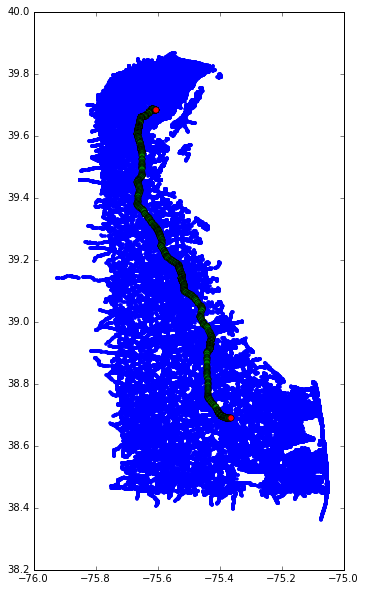

In [69]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot([node_coords(G, n)['lon'] for n in G], [node_coords(G, n)['lat'] for n in G], '.')
ax.plot([node_coords(G, n)['lon'] for n in path], [node_coords(G, n)['lat'] for n in path], 'o')
ax.plot([node_coords(G, n)['lon'] for n in ends], [node_coords(G, n)['lat'] for n in ends], 'o')
ax.set_aspect(aspect='equal')